In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT

from HQA import HQA, HQA_variation

from utils import *
import os

In [23]:
# Architecture parameters

virtual_qubits = 1024
# virtual_qubits = 64
qubits_per_core = 128
# qubits_per_core = 26
comm_qubits_per_link = np.arange(1, 6)

single_qubit_gate_time = 7.9e-9
two_qubit_gate_time = 30e-9
meas_time = 40e-9
EPR_time = 130e-9

single_qubit_gate_error = 7.42e-5
two_qubit_gate_error = 7e-4
meas_error = 1.67e-4
EPR_error = 9e-3
T1 = 1.2e-3
T2 = 1.16e-3
link_width = 15
proc_cycles = 2
clk_freq = 500e6


error_delta = 20
time_delta = 20

single_qubit_gate_time = single_qubit_gate_time/time_delta
two_qubit_gate_time = two_qubit_gate_time/time_delta
meas_time = meas_time/time_delta
EPR_time = EPR_time/time_delta
single_qubit_gate_error = single_qubit_gate_error/error_delta
two_qubit_gate_error = two_qubit_gate_error/error_delta
meas_error = meas_error/error_delta
EPR_error = EPR_error/error_delta
T1 = T1*time_delta
T2 = T2*time_delta

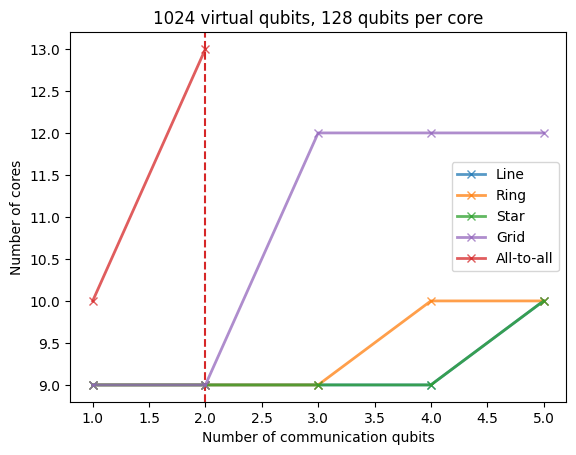

In [24]:
# Explore feasible configurations

line_capacities = [get_line_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_line_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
ring_capacities = [get_ring_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_ring_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
star_capacities = [get_star_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_star_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
grid_capacities = [get_grid_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_grid_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
all_to_all_capacities = [get_all_to_all_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_all_to_all_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]

plt.plot(comm_qubits_per_link[:len(line_capacities)], [len(cores) for cores in line_capacities], label="Line", marker='x', alpha=0.75, linewidth=2, color='tab:blue')
plt.plot(comm_qubits_per_link[:len(ring_capacities)], [len(cores) for cores in ring_capacities], label="Ring", marker='x', alpha=0.75, linewidth=2, color='tab:orange')
plt.plot(comm_qubits_per_link[:len(star_capacities)], [len(cores) for cores in star_capacities], label="Star", marker='x', alpha=0.75, linewidth=2, color='tab:green')
plt.plot(comm_qubits_per_link[:len(grid_capacities)], [len(cores) for cores in grid_capacities], label="Grid", marker='x', alpha=0.75, linewidth=2, color='tab:purple')
plt.plot(comm_qubits_per_link[:len(all_to_all_capacities)], [len(cores) for cores in all_to_all_capacities], label="All-to-all", marker='x', alpha=0.75, linewidth=2, color='tab:red')

if len(line_capacities) < len(comm_qubits_per_link) and len(line_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(line_capacities)-1], color='tab:blue', linestyle='--', zorder=-1)

if len(ring_capacities) < len(comm_qubits_per_link) and len(ring_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(ring_capacities)-1], color='tab:orange', linestyle='--', zorder=-1)

if len(star_capacities) < len(comm_qubits_per_link) and len(star_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(star_capacities)-1], color='tab:green', linestyle='--', zorder=-1)

if len(grid_capacities) < len(comm_qubits_per_link) and len(grid_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(grid_capacities)-1], color='tab:purple', linestyle='--', zorder=-1)

if len(all_to_all_capacities) < len(comm_qubits_per_link) and len(all_to_all_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(all_to_all_capacities)-1], color='tab:red', linestyle='--', zorder=-1)

plt.xlabel("Number of communication qubits")
plt.ylabel("Number of cores")

plt.title(f'{virtual_qubits} virtual qubits, {qubits_per_core} qubits per core')

plt.legend()
plt.show()

In [4]:
circ = QFT(virtual_qubits)
transp_circ = transpile(circ, basis_gates=['x', 'cx', 'cp', 'rz', 'h', 's', 'sdg', 't', 'tdg', 'measure'])
Gs, Gs_all = qiskit_circ_to_slices(transp_circ)

In [21]:
import numpy as np
import random
from joblib import Parallel, delayed

def run_trial(Gs, virtual_qubits, core_capacities, distance_matrix, comm_qubits, QCores, comp_time, single_qubit_gate_time, 
              two_qubit_gate_time, meas_time, EPR_time, single_qubit_gate_error, two_qubit_gate_error, meas_error, EPR_error, 
              T1, T2, link_width, proc_cycles, clk_freq, topology, packet_size):
    while True:
        try:
            random_partition = [i for i in range(len(core_capacities)) for _ in range(core_capacities[i])][:virtual_qubits]
            random.shuffle(random_partition)
            Ps = np.zeros((len(Gs) + 1, virtual_qubits), dtype=int)
            Ps[0] = random_partition
            
            Ps_HQA = HQA_variation(Gs, Ps.copy(), QCores, virtual_qubits, core_capacities.copy(), distance_matrix=distance_matrix)
            break
        except:
            print('Error in HQA, retrying')

    num_tlp_slices, link_usage = tlp_slices(Ps_HQA, virtual_qubits, QCores, comm_qubits=comm_qubits, 
                                            distance_matrix=distance_matrix, topology=topology)
    non_local_comm = sum(count_non_local_comms(Ps_HQA, QCores, distance_matrix))
    non_local_slice = sum(num_tlp_slices)

    operational_fidelity = get_operational_fidelity_depol(Gs, Ps_HQA, distance_matrix, single_qubit_gate_error, 
                                                          two_qubit_gate_error, meas_error, EPR_error)

    comm_times, _ = get_q_communications_time(link_usage, single_qubit_gate_time, two_qubit_gate_time, meas_time, 
                                              EPR_time, packet_size, link_width, proc_cycles, clk_freq, 1)
    comm_time = sum([sum([sum(tlp_tuple) for tlp_tuple in tlp_slice]) for tlp_slice in comm_times if not np.array_equal([0], tlp_slice)])

    total_time = comm_time + comp_time
    decoherence_over_time = np.exp(-total_time / T1) * (1 / 2 * np.exp(-total_time / T2) + 1 / 2)
    
    return comm_time, operational_fidelity, decoherence_over_time, non_local_comm, non_local_slice

def qlink_exploration(
        Gs, qubits_per_core, comm_qubits_per_link, single_qubit_gate_time, two_qubit_gate_time, meas_time, EPR_time,
        single_qubit_gate_error, two_qubit_gate_error, meas_error, EPR_error, T1, T2, link_width, proc_cycles, clk_freq,
        topology, trials):
    
    virtual_qubits = Gs[0].shape[0]
    comp_time = get_computation_time(Gs, single_qubit_gate_time, two_qubit_gate_time)

    comm_times_list = [[] for _ in comm_qubits_per_link]
    comp_times_list = [[] for _ in comm_qubits_per_link]
    operational_fidelity_list = [[] for _ in comm_qubits_per_link]
    time_decoherence_list = [[] for _ in comm_qubits_per_link]
    core_capacities_list = []
    non_local_comms = [[] for _ in comm_qubits_per_link]
    non_local_slices = [[] for _ in comm_qubits_per_link]

    for c, comm_qubits in enumerate(comm_qubits_per_link):
        print(f'Comm qubits: {comm_qubits}')
        core_capacities, distance_matrix = get_cores(virtual_qubits, comm_qubits, qubits_per_core, topology)
        
        if core_capacities == -1:
            print('Skipping')
            continue

        QCores = len(core_capacities)
        packet_size = 2 * np.ceil(np.log2(qubits_per_core * QCores)) + 2
        
        results = Parallel(n_jobs=-1)(delayed(run_trial)(Gs, virtual_qubits, core_capacities, distance_matrix, comm_qubits, QCores, comp_time,
                                                          single_qubit_gate_time, two_qubit_gate_time, meas_time, EPR_time, single_qubit_gate_error,
                                                          two_qubit_gate_error, meas_error, EPR_error, T1, T2, link_width, proc_cycles, clk_freq, topology, packet_size)
                                     for _ in range(trials))
        
        for comm_time, operational_fidelity, decoherence_over_time, non_local_comm, non_local_slice in results:
            comm_times_list[c].append(comm_time)
            comp_times_list[c].append(comp_time)
            operational_fidelity_list[c].append(operational_fidelity)
            time_decoherence_list[c].append(decoherence_over_time)
            non_local_comms[c].append(non_local_comm)
            non_local_slices[c].append(non_local_slice)

    return comp_times_list, comm_times_list, operational_fidelity_list, time_decoherence_list, core_capacities_list, non_local_comms, non_local_slices


In [22]:
comp_times_list, comm_times_list, operational_fid_list, time_decoherence_list, core_capacities_list, non_local_comms, non_local_slices = qlink_exploration(
        Gs_all,
        qubits_per_core,
        # comm_qubits_per_link,
        [1,2],
        single_qubit_gate_time,
        two_qubit_gate_time,
        meas_time,
        EPR_time,
        single_qubit_gate_error,
        two_qubit_gate_error,
        meas_error,
        EPR_error,
        T1,
        T2,
        link_width,
        proc_cycles,
        clk_freq,
        'line',
        5
)

Comm qubits: 1
Comm qubits: 2


In [12]:
total_time = [[comp_times_list[i][j] + comm_times_list[i][j] for j in range(len(comp_times_list[i]))] for i in range(len(comp_times_list))]
op_fid = [[operational_fid_list[i][j] for j in range(len(operational_fid_list[i]))] for i in range(len(operational_fid_list))]
estimated_fid = [[operational_fid_list[i][j] * time_decoherence_list[i][j] for j in range(len(operational_fid_list[i]))] for i in range(len(operational_fid_list))]

In [13]:
op_fid

[[0.8958768655878185,
  0.8920472994621452,
  0.8932710559169927,
  0.8923529902533345,
  0.8971058135596267],
 [0.8723969433948237,
  0.8794509003673521,
  0.8741917769245956,
  0.870307648438794,
  0.872397461231275],
 [0.8710579596349755,
  0.8662897113668496,
  0.8670345623107052,
  0.8559662095983174,
  0.8713508595284903],
 [0.8440287699232029,
  0.8371213096817927,
  0.8341086692718781,
  0.8356884282776196,
  0.8485214484059318],
 [0.7441320014055572,
  0.742476363271824,
  0.7487254224609166,
  0.7570874903800949,
  0.7471752914442454]]

In [14]:
estimated_fid

[[0.8952017069328944,
  0.8913456670221738,
  0.8925604429107379,
  0.8916537873226953,
  0.8964324130012382],
 [0.8716494286802172,
  0.878717075206082,
  0.8734728019725682,
  0.8696140012539928,
  0.871640811018047],
 [0.8703389559571062,
  0.8655694598983853,
  0.8663098004772986,
  0.8552391757911705,
  0.8706277036030926],
 [0.8432361238763381,
  0.8363576892792771,
  0.833309120464763,
  0.8348861152066052,
  0.847733467517058],
 [0.7431204794011579,
  0.7414537714386475,
  0.7476684791003256,
  0.7560289291224541,
  0.7460993136084585]]

In [15]:
non_local_comms

[[418, 468, 452, 464, 402],
 [728, 634, 704, 756, 728],
 [746, 810, 800, 950, 742],
 [1114, 1210, 1252, 1230, 1052],
 [2586, 2612, 2514, 2384, 2538]]